# Introducción: Transformaciones básicas de JAX

[JAX](https://github.com/google/jax) es un framework reciente enfocado en computación científica cuyos componentes principales son:

- *Autograd*: Un sistema para obtener derivadas de todo orden.
- *Accelerated Linear Algebra* (XLA): Un compilador enfocado en álgebra lineal.

Ambos aplican para rutinas escritas en Python nátivo o basadas en la librería [NumPy](https://numpy.org/). En conjunto permiten diferenciar, vectorizar, paralelizar y compilar a coprocesador GPU/TPU rutinas matemáticas.

> JAX es ideal para Machine Learning.

Veremos algunas de sus bondades a continuación.

## Instalación

JAX soporta oficialmente Linux y macOS. Hay soporte limitado y no oficial para Windows, [pero requiere compilación manual de las fuentes](https://jax.readthedocs.io/en/latest/developer.html#additional-notes-for-building-jaxlib-from-source-on-windows).

:::{note}

Si tienes SO Windows puedes experimentar con JAX en [google colab](https://colab.research.google.com/). En lo que sigue se asume una instalación local de JAX.

:::

Para instalar JAX lo más simple es utilizar el manejador de paquetas [conda](https://docs.conda.io/en/latest/miniconda.html). Para instalar JAX con soporte GPU, crea un ambiente de conda, actívalo y ejecuta el siguiente comando:

    conda install jax cuda-nvcc -c conda-forge -c nvidia
    
Si sólo vas a usar arquitecturas CPU puedes hacer una instalación más ligera con:

    conda install jax -c conda-forge
    
JAX también puede instalarse con pip (distintos sabores):

    pip install "jax[cpu]"
    pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    pip install "jax[tpu]>=0.2.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
    
    
Una vez instalado podemos verificar los dispositivos compatibles para hacer cómputo con:

In [1]:
import jax
jax.devices()

[CpuDevice(id=0)]

que en este caso indica que sólo está disponible un dispositivo CPU.

## JAX arrays y `jax.numpy`

Consideremos un `ndarray` con 10000 filas y 2 columnas y una función basada en la API de NumPy que calcula la distancia euclidiana entre todos los pares de filas:

In [2]:
import numpy as np

data = np.random.randn(10000, 2)

def distancia_pares_np(data):
    return np.sqrt(np.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

print(type(data))

%timeit -r3 -n1 distancia_pares_np(data)

<class 'numpy.ndarray'>
6.86 s ± 181 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Para acelerar esta función con JAX haremos dos cambios:

- Reemplazar los llamados a `numpy` por llamados a [`jax.numpy`](https://jax.readthedocs.io/en/latest/jax.numpy.html)
- Expresar los datos de entrada como un arreglo de JAX (`DeviceArray`)

El segundo es en realidad opcional (pero necesario si queremos usar JIT)

In [3]:
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

def distancia_pares_jnp(data):
    return jnp.sqrt(jnp.sum((data.reshape(-1, 1, 2) - data.reshape(1, -1, 2))**2, axis=-1))

jax_data = jnp.array(data, dtype=jnp.float64)
print(type(jax_data))

print(np.allclose(distancia_pares_np(data), distancia_pares_jnp(jax_data)))
%timeit -r3 -n3 distancia_pares_jnp(data).block_until_ready()
%timeit -r3 -n3 distancia_pares_jnp(jax_data).block_until_ready()

<class 'jaxlib.xla_extension.DeviceArray'>
True
2.82 s ± 20.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
637 ms ± 2.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


El mismo resultado con un orden de magnitud de diferencia en términos de velocidad. Además, la  función en JAX es idéntica a la original.

> Es muy simple utilizar JAX si ya estamos utilizando NumPy

:::{note}

Por defecto JAX trabaja con flotantes de 32 bits (*single precision*) ya que está pensando en arquitecturas GPU y TPU. Se puede activar manualmente la precisión doble como se mostró en el ejemplo anterior.

:::

Los arreglos en JAX se representan con objectos `DeviceArray`. Este objeto puede vivir en memoria de CPU, GPU y TPU. JAX realizará los cómputos de acuerdo a donde están alojados los arreglos. 

Podemos consultar donde está alojado un `DeviceArray` con:

In [4]:
x = jnp.array([0., 1., 2.])
x.device_buffer.device()

CpuDevice(id=0)

Y podemos transferirlo a otros dispositivos disponibles con [`device_put`](https://jax.readthedocs.io/en/latest/_autosummary/jax.device_put.html#jax.device_put):

In [5]:
jax.device_put(x, device=jax.devices()[0])

DeviceArray([0., 1., 2.], dtype=float64)

`jax.numpy` y `DeviceArray` siguen de forma bastante directa a `numpy` y `ndarray` [con algunas excepciones notables](https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html#differences-from-numpy), como por ejemplo:

:::{warning}

Los arreglos de tipo `DeviceArray` son inmutables. Una vez creados no pueden modificarse.

:::

Por ejemplo ejecutar

```python
x = jnp.array([0., 1., 2.])
x[0] = 1.
```

Levantará una excepción de tipo `TypeError`

## Compilación JIT

JAX permite compilación de tipo Just-in-time (JIT) en base a la tecnología XLA. Esto se logra con la transformación `jax.jit`, que también puede invocarse como decorador `@jit`.

Por ejemplo si "jitificamos" `distancia_pares_jnp`:

In [6]:
distancia_pares_jit = jax.jit(distancia_pares_jnp)

print(np.allclose(distancia_pares_np(data), distancia_pares_jit(jax_data)))
%timeit -r3 -n3 distancia_pares_jit(jax_data).block_until_ready()

True
229 ms ± 17.2 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Resultado equivalente pero tres veces más rápido que la versión de `jax.numpy`

:::{note}

La compilación ocurre al ejecutar por primera vez una función transformada con `jax.jit`. Internamente JAX realiza un trazado de la función en base a su entrada para verificar si es pura y luego la lleva a un lenguaje intermedio llamado [jaxpr](https://jax.readthedocs.io/en/latest/jaxpr.html). La compilación tiene un *overhead* importante pero ejecuciones subsecuentes serán mucho más veloces.

:::

Sin embargo, [existen ciertas restricciones](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#why-can-t-we-just-jit-everything) para utilizar `jit`.

:::{warning}

`jit` sólo puede aplicarse a funciones que ["funcionalmente puras"](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions). Una función pura:

- Debe entregar siempre el mismo resultado si se entregan las mismas entradas.
- No debe cambiar su comportamiento en base al valor de su entrada (prohibido los if/else a menos [que sean estos](https://jax.readthedocs.io/en/latest/jax.lax.html#control-flow-operators))
- No debe utilizar variables globales o fuera de su *scope*.
- No debe tener *side-effects* (por ejemplo llamadas a I/O).

:::

Se pueden marcar algunas variables como estáticas (no "jitificables") con el argumento `static_argnums` de `jax.jit`

## Autodiferenciación

La siguiente transformación que revisaremos es [`jax.grad`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html). Esta transformación recibe una función y retorna otra función que corresponde a su gradiente. Algunas restricciones de la función original:

- Debe recibir argumentos flotantes (single o double).
- Debe retornar un valor escalar.

Veamos un ejemplo, y comparemos el resultado contra la deriviada analítica de la función:

In [7]:
def sigmoid(x): 
    return 1.0/(1.0 + jnp.exp(-x))

diff_sigmoid = jax.grad(sigmoid)

for x in jnp.linspace(-3., 3., 11):
    print(f"x:{x:0.4f}\tdf(x)/dx:{diff_sigmoid(x):0.4f}\t f(x)(1-f(x)):{sigmoid(x)*(1.-sigmoid(x)):0.4f}")

x:-3.0000	df(x)/dx:0.0452	 f(x)(1-f(x)):0.0452
x:-2.4000	df(x)/dx:0.0763	 f(x)(1-f(x)):0.0763
x:-1.8000	df(x)/dx:0.1217	 f(x)(1-f(x)):0.1217
x:-1.2000	df(x)/dx:0.1779	 f(x)(1-f(x)):0.1779
x:-0.6000	df(x)/dx:0.2288	 f(x)(1-f(x)):0.2288
x:0.0000	df(x)/dx:0.2500	 f(x)(1-f(x)):0.2500
x:0.6000	df(x)/dx:0.2288	 f(x)(1-f(x)):0.2288
x:1.2000	df(x)/dx:0.1779	 f(x)(1-f(x)):0.1779
x:1.8000	df(x)/dx:0.1217	 f(x)(1-f(x)):0.1217
x:2.4000	df(x)/dx:0.0763	 f(x)(1-f(x)):0.0763
x:3.0000	df(x)/dx:0.0452	 f(x)(1-f(x)):0.0452


JAX está diseñado para componer sus transformaciones. Por ejemplo es muy simple componer `grad` con `jit`:

In [8]:
jit_diff_sigmoid = jax.jit(diff_sigmoid)
print(np.allclose(diff_sigmoid(0.01), jit_diff_sigmoid(0.01)))

%timeit -r10 -n10 diff_sigmoid(0.01).block_until_ready()
%timeit -r10 -n10 jit_diff_sigmoid(0.01).block_until_ready()

True
4.21 ms ± 382 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
The slowest run took 6.81 times longer than the fastest. This could mean that an intermediate result is being cached.
8.66 µs ± 9.09 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


Podemos también componer `grad` consigo mismo para obtener derivadas de mayor orden:

In [9]:
def poly(x): 
    return x**2 + 2*x + 3.

dpoly = jax.grad(poly)
d2poly = jax.grad(dpoly)
d3poly = jax.grad(d2poly)

for x in jnp.linspace(-3., 3., 11):
    print(f"x:{x:0.4f}\tdf:{dpoly(x):0.4f}\t df2:{d2poly(x):0.4f}\t df3:{d3poly(x):0.4f}")

x:-3.0000	df:-4.0000	 df2:2.0000	 df3:0.0000
x:-2.4000	df:-2.8000	 df2:2.0000	 df3:0.0000
x:-1.8000	df:-1.6000	 df2:2.0000	 df3:0.0000
x:-1.2000	df:-0.4000	 df2:2.0000	 df3:0.0000
x:-0.6000	df:0.8000	 df2:2.0000	 df3:0.0000
x:0.0000	df:2.0000	 df2:2.0000	 df3:0.0000
x:0.6000	df:3.2000	 df2:2.0000	 df3:0.0000
x:1.2000	df:4.4000	 df2:2.0000	 df3:0.0000
x:1.8000	df:5.6000	 df2:2.0000	 df3:0.0000
x:2.4000	df:6.8000	 df2:2.0000	 df3:0.0000
x:3.0000	df:8.0000	 df2:2.0000	 df3:0.0000


Por defecto la diferenciación se hace contra el primer argumento de la función. Para funciones con múltiples argumentos podemos modificar este comportamiento con el argumento `argnums` de `jax.grad`.


In [10]:
def f(x, w): 
    return jnp.dot(x,w)

x = jnp.array([-2., 2.])
w = jnp.array([1., -1.])

dfdx = jax.grad(f, argnums=0)
print(dfdx(x, w))

dfdw = jax.grad(f, argnums=1)
print(dfdw(x, w))

[ 1. -1.]
[-2.  2.]


:::{note}

JAX también tiene transformaciones para [calcular jacobianos y hessianos](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev), lo cual vuelve bastante factible la utilización de algoritmos de segundo orden para optimizar.

:::

## Vectorización

La última transformación que revisaremos es [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html). Esta transformación recibe una función para valores escalares y retorna otra función que se puede aplicar sobre arreglos, es decir vectoriza automaticamente la función original. 

Esta transformación se puede componer con `grad` y con `jit`:

In [11]:
def f(x): 
    return 1.0/(1.0 + jnp.exp(-x))

df = jax.grad(f) # Recibe y retorna escalares
vdf = jax.vmap(df) # Recibe y retorna arreglos
vdf_jit = jax.jit(vdf) 

x = jnp.linspace(-5, 5, 1000)
print(np.allclose(vdf(x), vdf_jit(x)))
%timeit -r3 -n3 jnp.array([df(x_) for x_ in x])
%timeit -r3 -n3 vdf(x).block_until_ready()
%timeit -r3 -n3 vdf_jit(x).block_until_ready()

True
4.43 s ± 108 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
5.96 ms ± 241 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
The slowest run took 5.58 times longer than the fastest. This could mean that an intermediate result is being cached.
46.9 µs ± 39.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
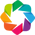

:Overlay
   .Curve.F_left_parenthesis_x_right_parenthesis :Curve   [x]   (y)
   .Curve.Df_over_dx                             :Curve   [x]   (y)

In [12]:
import holoviews as hv
hv.extension('bokeh')
hv.opts.defaults(hv.opts.Curve(width=400))

hv.Curve((x, f(x)), label='f(x)') * hv.Curve((x, vdf_jit(x)), label='df/dx')

Típicamente utilizaremos esta transformación cuando tengamos una función que debe aplicarse sobre un *batch* de datos de forma independiente: *Single Instruction Multiple Data* (SIMD) 

Digamos que tenemos un dataset $x\in \mathbb{R}^{NxD}$ y para cada fila $i$ necesitamos calcular:

$$
y_i = w_0 + \sum_{j=1}^D w_j x_{ij}
$$

con JAX esto sería:

In [13]:
def Dense(x, w): 
    return w[0] + jnp.sum(w[len(x):]*x)

N, D = 5, 3
data = jnp.ones(shape=(N, D))
param = jnp.ones(shape=(D+1)) 

vDense = jax.jit(jax.vmap(Dense, in_axes=[0, None]))

vDense(data, param)

DeviceArray([4., 4., 4., 4., 4.], dtype=float64)

Podemos especificar cual dimensión del tensor de entrada y salida queremos vectorizar con los argumentos `in_axes` y `out_axes` de `jax.vmap`, respectivamente. 


## Generación de números aleatorios

Existen algunas diferencias importantes entre el generador de números pseudo-aleatorios (PRNG) de NumPy y de JAX. La primera es que las rutins de PRNG de JAX están en [`jax.random`](https://jax.readthedocs.io/en/latest/jax.random.html) en vez de `jax.numpy.random` que sería lo esperable.

Lo segundo y más fundamental, es que JAX no mantiene el estado del PRNG de manera global. En su lugar, es el usuario el que debe mantener el estado.

Veamos que significa en la práctica:

In [14]:
np.random.seed(1234) # Configura el estado inicial de forma global
for i in range(3):
    print(np.random.randn()) # Cada llamada actualiza el estado global

0.47143516373249306
-1.1909756947064645
1.4327069684260973


En JAX, las funciones de `jax.random` esperan una llave:

In [15]:
import jax.random as random

key = random.PRNGKey(1234) # Estado inicial
for i in range(3):
    print(random.normal(key)) # Ocupa la llave, pero la actualiza

0.4395758528880331
0.4395758528880331
0.4395758528880331


Si utilizamos la misma llave obtendremos el mismo resultado. Para no reutilizar una llave podemos utilizar `random.split`:

In [16]:
import jax.random as random

key = random.PRNGKey(1234)
for i in range(3):
    key, subkey = random.split(key) # Genera dos llaves nuevas
    print(random.normal(subkey)) 

-1.7366326757754018
-0.74630100088392
-0.17782682174856315


`random.split` recibe como argumento opcional `num` la cantidad de llaves nuevas a generar

> Esta "complicación extra" es fundamental para poder vectorizar eficientemente cómputos que involucren PRNG

## Otros detalles sobre JAX

- Las llamadas en JAX se realizan de [forma asíncrona](https://jax.readthedocs.io/en/latest/async_dispatch.html). Es por esto que para medir tiempos forzabamos sincronía con `.block_until_ready()`.
- `jax.numpy` está construido en base al módulo de bajo nivel [`jax.lax`](https://jax.readthedocs.io/en/latest/jax.lax.html), el cual es más estricto pero más eficiente.
- JAX soporta paralelismo, es decir cómputos que usan más de un nucleo de CPU o más de una GPU. La transformación para implementar paralelismo es [`jax.pmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html). 


Reviews y comparativas:

- https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/
- http://www.echonolan.net/posts/2021-09-06-JAX-vs-PyTorch-A-Transformer-Benchmark.html
- https://dzone.com/articles/accelerated-automatic-differentiation-with-jax-how